In [3]:
#importing the libraries for dataset
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [4]:
#Import daily train and test sets (from ARIMA time series models) to use for RRN-LTSM models
WTI_train = pd.read_csv('WTI_train.csv')
WTI_test = pd.read_csv('WTI_test.csv')
BRENT_train = pd.read_csv('BRENT_train.csv')
BRENT_test = pd.read_csv('BRENT_test.csv')

In [76]:
WTI_train['date'] = pd.to_datetime(WTI_train['date'],yearfirst=True)
WTI_test['date'] = pd.to_datetime(WTI_test['date'],yearfirst=True)
BRENT_train['date'] = pd.to_datetime(BRENT_train['date'],yearfirst=True)
BRENT_test['date'] = pd.to_datetime(BRENT_test['date'],yearfirst=True)
WTI_train= WTI_train.rename(columns={"WTI": "WTI_train"})
WTI_test= WTI_test.rename(columns={"WTI": "WTI_test"})
BRENT_train= BRENT_train.rename(columns={"BRENT": "BRENT_train"})
BRENT_test= BRENT_test.rename(columns={"BRENT": "BRENT_test"})
WTI_train.set_index('date')
WTI_train.index = pd.to_datetime(WTI_train['date'],yearfirst=True)
WTI_test.set_index('date')
WTI_test.index = pd.to_datetime(WTI_test['date'],yearfirst=True)
BRENT_train.set_index('date')
BRENT_train.index = pd.to_datetime(BRENT_train['date'],yearfirst=True)
BRENT_test.set_index('date')
BRENT_test.index = pd.to_datetime(BRENT_test['date'],yearfirst=True)

In [6]:
WTI_train_data=WTI_train.iloc[:,1:2].values
WTI_test_data=WTI_test.iloc[:,1:2].values
BRENT_train_data=BRENT_train.iloc[:,1:2].values
BRENT_test_data=BRENT_test.iloc[:,1:2].values

In [7]:
#Scale and normalize the oil price data to (0, 1) values by creating a scalar object.   
scaler=MinMaxScaler(feature_range=(0,1))
WTI_scaled_train_data=scaler.fit_transform(WTI_train_data)
WTI_scaled_test_data=scaler.fit_transform(WTI_test_data)
BRENT_scaled_train_data=scaler.fit_transform(BRENT_train_data)
BRENT_scaled_test_data=scaler.fit_transform(BRENT_test_data)

In [8]:
print(WTI_scaled_train_data.shape, WTI_scaled_test_data.shape, BRENT_scaled_train_data.shape, BRENT_scaled_test_data.shape)

(7218, 1) (351, 1) (7218, 1) (351, 1)


# RNN-LTSM Model for WTI Daily Data

In [101]:
# Create a data structure with 60 lags
WTI_X_train=[]
WTI_y_train=[]
for i in range(60,len(WTI_scaled_train_data)):
    WTI_X_train.append(WTI_scaled_train_data[i-60:i,0])
    WTI_y_train.append(WTI_scaled_train_data[i,0])

#Converting the data to the numpy array as it is expected by our RNN model
WTI_X_train=np.array(WTI_X_train)
WTI_y_train=np.array(WTI_y_train)    

#Reshaping training data to the following format (# values, # time steps, #1 dimensional output)
WTI_X_train=np.reshape(WTI_X_train,(WTI_X_train.shape[0],WTI_X_train.shape[1],1))
print(WTI_X_train.shape)    


(7158, 60, 1)


In [ ]:
#Build the LTSM model (LTSM with 50 neurons and 4 hidden layers using the MSE loss function and the Adam stoachastic gradient descent optimizer)
#(See https://medium.com/ai-in-plain-english/time-series-forecasting-predicting-stock-prices-using-an-lstm-model-30d6f1ca2640)

WTI_model=Sequential()

#Adding the first layer and dropout regularization
WTI_model.add(LSTM(units=50,return_sequences=True,input_shape=(WTI_X_train.shape[1],1)))
WTI_model.add(Dropout(0.2))
#Second layer
WTI_model.add(LSTM(units=50,return_sequences=True))
WTI_model.add(Dropout(0.2))
#Third layer
WTI_model.add(LSTM(units=50,return_sequences=True))
WTI_model.add(Dropout(0.2))
#Fourth Layer
WTI_model.add(LSTM(units=50,return_sequences=False))
WTI_model.add(Dropout(0.2))
#Output Layer
WTI_model.add(Dense(units=1))

#Compiling the RNN model
WTI_model.compile(optimizer='adam',loss='mean_squared_error')

#fitting the RNN model on our training dataset
WTI_model.fit(WTI_X_train,WTI_y_train,epochs=100,batch_size=32)



Epoch 1/100
224/224 [==============================] - 62s 276ms/step - loss: 0.0044
Epoch 2/100
224/224 [==============================] - 76s 340ms/step - loss: 0.0018
Epoch 3/100
224/224 [==============================] - 68s 302ms/step - loss: 0.0015
Epoch 4/100
224/224 [==============================] - 54s 243ms/step - loss: 0.0013
Epoch 5/100
224/224 [==============================] - 57s 255ms/step - loss: 0.0012
Epoch 6/100
224/224 [==============================] - 53s 236ms/step - loss: 0.0011
Epoch 7/100
224/224 [==============================] - 58s 261ms/step - loss: 0.0011
Epoch 8/100
224/224 [==============================] - 55s 244ms/step - loss: 0.0010
Epoch 9/100
224/224 [==============================] - 62s 277ms/step - loss: 9.3071e-04
Epoch 10/100
224/224 [==============================] - 59s 263ms/step - loss: 9.3447e-04
Epoch 11/100
224/224 [==============================] - 61s 271ms/step - loss: 8.8525e-04
Epoch 12/100
224/224 [=============================

In [ ]:
#Preparing and reshaping test data 
WTI_dataset_total=pd.concat((WTI_train["WTI_train"], WTI_test["WTI_test"]), axis=0)
WTI_inputs = WTI_dataset_total[len(WTI_dataset_total) - len(WTI_test_data) - 60:].values

WTI_inputs = WTI_inputs.reshape(-1,1)
WTI_inputs = scaler.transform(WTI_inputs)
WTI_X_test = []
for i in range(60, len(WTI_scaled_test_data)):
    WTI_X_test.append(WTI_inputs[i-60:i, 0])
    
WTI_X_test = np.array(WTI_scaled_test_data)
WTI_X_test = np.reshape(WTI_X_test, (WTI_X_test.shape[0], WTI_X_test.shape[1], 1))
print(WTI_X_test.shape)

In [ ]:
# setting dates for the prediction index
prediction_index= BRENT_test["date"].iloc[60:]
prediction_index

In [ ]:
#Making predictions using the test data
prediction_index= WTI_test["date"]
WTI_predictions=WTI_model.predict(WTI_X_test)
WTI_predictions=scaler.inverse_transform(WTI_predictions)
WTI_predictions = pd.DataFrame(WTI_predictions,index=prediction_index.index)
WTI_predictions

In [ ]:
#Adjusting test data to account for lag of 60 
WTI_test60=WTI_test_data[60:]

In [ ]:
#Calculate the model fit and accuracy scores of RNN-LTSM model for predicting WTI test data 
WTI_accuracy = metrics.r2_score(WTI_test_data, WTI_predictions)
WTI_MSE = metrics.mean_squared_error(WTI_test_data, WTI_predictions)

print(f'the RNN-LTSM Model Fit for predicting WTI oil price data is: R2 = {WTI_accuracy} and MSE = {WTI_MSE}')

In [ ]:
#Visualising the predictions and original data

plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(WTI_train["WTI_train"],label="WTI Train")
plt.plot(WTI_test["WTI_test"], label = "WTI Daily Test")
plt.plot(WTI_predictions, label = "RNN-LTSM WTI Predicted")
plt.title(f'RNN-LTSM model for WTI Daily Oil Price Over Time; MSE = {WTI_MSE}')
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.legend()
plt.show()

# RNN-LTSM Model for BRENT Daily Data

In [99]:
# Create a data structure with 60 time-steps and 1 output 
BRENT_X_train=[]
BRENT_y_train=[]
for i in range(60,len(BRENT_scaled_train_data)):
    BRENT_X_train.append(BRENT_scaled_train_data[i-60:i,0])
    BRENT_y_train.append(BRENT_scaled_train_data[i,0])

#Converting the data to the numpy array as it is expected by our RNN model
BRENT_X_train=np.array(BRENT_X_train)
BRENT_y_train=np.array(BRENT_y_train)    

#Reshaping training data to the following format (# values, # time steps, #1 dimensional output)
BRENT_X_train=np.reshape(BRENT_X_train,(BRENT_X_train.shape[0],BRENT_X_train.shape[1],1))
print(BRENT_X_train.shape)

(7158, 60, 1)


In [35]:
#Build the LTSM model (LTSM with 50 neurons and 4 hidden layers using the MSE loss function and the Adam stoachastic gradient descent optimizer)
#(See https://medium.com/ai-in-plain-english/time-series-forecasting-predicting-stock-prices-using-an-lstm-model-30d6f1ca2640)

BRENT_model=Sequential()

#Adding the first layer and dropout regularization
BRENT_model.add(LSTM(units=50,return_sequences=True,input_shape=(BRENT_X_train.shape[1],1)))
BRENT_model.add(Dropout(0.2))
#Second layer
BRENT_model.add(LSTM(units=50,return_sequences=True))
BRENT_model.add(Dropout(0.2))
#Third layer
BRENT_model.add(LSTM(units=50,return_sequences=True))
BRENT_model.add(Dropout(0.2))
#Fourth Layer
BRENT_model.add(LSTM(units=50,return_sequences=False))
BRENT_model.add(Dropout(0.2))
#Output Layer
BRENT_model.add(Dense(units=1))

#Compiling the RNN model
BRENT_model.compile(optimizer='adam',loss='mean_squared_error')

#fitting the RNN model on our training dataset
BRENT_model.fit(BRENT_X_train,BRENT_y_train,epochs=100,batch_size=32)


Epoch 1/100
224/224 [==============================] - 28s 123ms/step - loss: 0.0052
Epoch 2/100
224/224 [==============================] - 29s 131ms/step - loss: 0.0020
Epoch 3/100
224/224 [==============================] - 31s 140ms/step - loss: 0.0020
Epoch 4/100
224/224 [==============================] - 32s 141ms/step - loss: 0.0015
Epoch 5/100
224/224 [==============================] - 32s 143ms/step - loss: 0.0014
Epoch 6/100
224/224 [==============================] - 32s 142ms/step - loss: 0.0013
Epoch 7/100
224/224 [==============================] - 31s 141ms/step - loss: 0.0013
Epoch 8/100
224/224 [==============================] - 31s 140ms/step - loss: 0.0012
Epoch 9/100
224/224 [==============================] - 34s 151ms/step - loss: 0.0011
Epoch 10/100
224/224 [==============================] - 35s 156ms/step - loss: 9.9241e-04
Epoch 11/100
224/224 [==============================] - 31s 139ms/step - loss: 9.7742e-04
Epoch 12/100
224/224 [==============================] -

In [43]:
#Preparing and reshaping test data 
BRENT_dataset_total=pd.concat((BRENT_train["BRENT_train"], BRENT_test["BRENT_test"]), axis=0)
BRENT_inputs = BRENT_dataset_total[len(BRENT_dataset_total) - len(BRENT_test_data) - 60:].values

BRENT_inputs = BRENT_inputs.reshape(-1,1)
BRENT_inputs = scaler.transform(BRENT_inputs)
BRENT_X_test = []
for i in range(60, len(BRENT_scaled_test_data)):
    BRENT_X_test.append(BRENT_inputs[i-60:i, 0])
BRENT_X_test = np.array(BRENT_X_test)
BRENT_X_test = np.reshape(BRENT_X_test, (BRENT_X_test.shape[0], BRENT_X_test.shape[1], 1))
print(BRENT_X_test.shape)

(291, 60, 1)


In [45]:
#setting prediction index
prediction_index= BRENT_test["date"].iloc[60:]
prediction_index

date
2019-03-29   2019-03-29
2019-04-01   2019-04-01
2019-04-02   2019-04-02
2019-04-03   2019-04-03
2019-04-04   2019-04-04
                ...    
2020-05-22   2020-05-22
2020-05-26   2020-05-26
2020-05-27   2020-05-27
2020-05-28   2020-05-28
2020-05-29   2020-05-29
Name: date, Length: 291, dtype: datetime64[ns]

In [46]:
#Making predictions using the test data
BRENT_predictions=BRENT_model.predict(BRENT_X_test)
BRENT_predictions=scaler.inverse_transform(BRENT_predictions)
BRENT_predictions = pd.DataFrame(BRENT_predictions,index=prediction_index.index)
BRENT_predictions

,0
date,
2019-03-29,49.891418
2019-04-01,52.270546
2019-04-02,52.503563
2019-04-03,54.509014
2019-04-04,56.351185
...,...
2020-05-22,56.869152
2020-05-26,55.503220
2020-05-27,54.623158


In [81]:
#Adjusting test data for lag of 60
BRENT_test60=BRENT_test_data[60:]

In [83]:
#Calculate the model fit and accuracy scores of RNN-LTSM model for predicting BRENT test data 
BRENT_accuracy = metrics.r2_score(BRENT_test60, BRENT_predictions)
BRENT_MSE = metrics.mean_squared_error(BRENT_test60, BRENT_predictions)

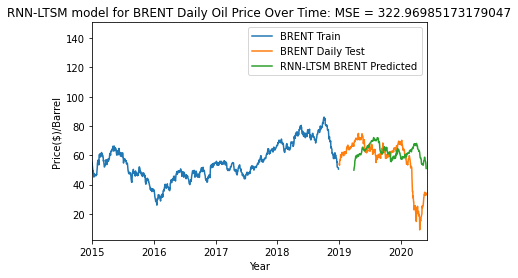

In [88]:
#Visualising the predictions and original data
plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(BRENT_train["BRENT_train"],label="BRENT Train")
plt.plot(BRENT_test["BRENT_test"], label = "BRENT Daily Test")
plt.plot(BRENT_predictions, label = "RNN-LTSM BRENT Predicted")
plt.title(f'RNN-LTSM model for BRENT Daily Oil Price Over Time: MSE = {BRENT_MSE}')
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.legend()
plt.show()